# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

import os

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

# Y_train_8 = pd.read_csv('Data/Y_train_8.csv', header=None, delimiter=',').values
# Y_test_8 = pd.read_csv('Data/Y_test_8.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [4]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# train_y_8 = torch.tensor(Y_train_8, dtype=torch.float32)
# test_y_8 = torch.tensor(Y_test_8, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)

## PCA of output

In [ ]:
pca_20 = PCA(n_components = 20)

pca_20.fit(train_y[:,1:])
torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
torch.set_num_interop_threads(4)

# Emulators

In [5]:
Device = 'cpu'

In [18]:
row_idx = 0

input_point = test_y[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = 100)

bounds = bound.get_bounds(local_train_x)

### LocalGP

In [ ]:
output_file = 'Result/LocalGP_21_result.csv'


if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('Iteration,test_preds,estimated_params,posterior_means\n')



In [ ]:
row_idx = 0


input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=100)

LocalGP_models, LocalGP_likelihoods = Training.train_one_row_LocalGP_Parallel(
    train_x, train_y_21, test_y_21, row_idx,
    covar_type='RBF', k_num=100, lr=0.025,
    num_iterations=5000, patience=10, device=Device
)


In [ ]:
preds_tmp = Prediction.full_preds(
    LocalGP_models, LocalGP_likelihoods, test_x[row_idx, :].unsqueeze(0).to(Device)
).cpu().detach().numpy()



estimated_params_tmp, _ = Estimation.multi_start_estimation(
    LocalGP_models, LocalGP_likelihoods, row_idx, test_y_21, bounds,
    Estimation.estimate_params_Adam, num_starts=5, num_iterations=2000, lr=0.01,
    patience=50, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
)




In [ ]:
def train_and_predict_LocalGP(row_idx, train_x, train_y, test_x, test_y, K_num = 100, Device = 'cpu', PCA_trans = 'None'):

    LocalGP_models, LocalGP_likelihoods = Training.train_one_row_LocalGP(
        train_x, train_y, test_y, row_idx, covar_type = 'RQ', k_num=K_num, lr=0.05, num_iterations=5000, patience=10, device=Device
    )
    
    preds = Prediction.full_preds(LocalGP_models, LocalGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).cpu().detach().numpy()
    if PCA_trans != 'None':
        preds = PCA_trans.inverse_transform(preds)

    return preds




In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_LocalGP)(row_idx, train_x, train_y, test_x, test_y, PCA_trans = pca_20) for row_idx in range(test_y.shape[0]))
full_test_preds_LocalGP = np.vstack(results)

MSE_LocalGP = np.mean((full_test_preds_LocalGP - test_y.numpy()) ** 2)

In [ ]:
MSE_LocalGP

In [ ]:
MSE_LocalGP

### MultiGP

In [ ]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 100)


MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
                                                                                 covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=10, device=Device)


In [ ]:
Prediction.preds_for_one_model(MultitaskGP_models, MultitaskGP_likelihoods, theta.unsqueeze(0)).view(-1)

In [ ]:
def train_and_predict_MGP(row_idx, train_x, train_y, test_x, test_y, K_num = 300, Device = 'cpu', PCA_trans = 'None'):


    input_point = test_y[row_idx,:]
    local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = K_num)

    MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(local_train_x, local_train_y, n_tasks = train_y.shape[1], covar_type = 'RQ', 
                                                                                     lr=0.05, num_iterations=10000, patience=10, device=Device)

    preds = Prediction.preds_for_one_model(MultitaskGP_models, MultitaskGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).detach().numpy()
    if PCA_trans != 'None':
        preds = PCA_trans.inverse_transform(preds)

    return preds



In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_MGP)(row_idx, train_x, train_y, test_x, test_y) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


np.mean((full_test_preds_MGP - test_y.numpy()) ** 2)

### NN + MultiGP

In [8]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 500)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
                                                                                   feature_extractor_class = FeatureE.FeatureExtractor_4, covar_type = 'Matern5/2', 
                                                                                   lr=0.05, num_iterations=5000, patience=10, device = Device)
    

In [ ]:
def train_and_predict_NNMGP(row_idx, train_x, train_y, test_x, test_y, K_num = 500, Device = 'cpu', PCA_trans = 'None'):


    input_point = test_y[row_idx,:]
    local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = K_num)

    NNMultitaskGP_models, NNMultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(local_train_x, local_train_y, n_tasks = train_y.shape[1], 
                                                                                            feature_extractor_class = FeatureE.FeatureExtractor_4, covar_type = 'RQ', 
                                                                                            lr=0.05, num_iterations=5000, patience=10, device = Device)

    preds = Prediction.preds_for_one_model(NNMultitaskGP_models, NNMultitaskGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).squeeze().detach().numpy()
    if PCA_trans != 'None':
        # preds = PCA_trans.inverse_transform(preds)
        first_column = preds[0]
        remaining_columns = preds[1:]
        remaining_columns = PCA_trans.inverse_transform(remaining_columns)
        preds = np.concatenate((first_column, remaining_columns), axis=1)

    return preds



In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y, test_x, test_y) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


MSE_NNMGP = np.mean((full_test_preds_MGP - test_y.numpy()) ** 2)

In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y_21, test_x, test_y_21) for row_idx in range(test_y.shape[0]))
# results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y_21, test_x, test_y_21) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


MSE_NNMGP_20 = np.mean((full_test_preds_MGP - test_y_21.numpy()) ** 2)
MSE_NNMGP_20

In [ ]:
MSE_NNMGP_20

### VGP

In [ ]:
inducing_points = train_x[:600, :].to(Device)
VGP_models, VGP_likelihoods = Training.train_full_VGP_Parallel(train_x, train_y_21, inducing_points, covar_type = 'RQ', lr=0.025, num_iterations=5000, patience=30, device=Device)


### MVGP

In [ ]:
MVGP_models, MVGP_likelihoods = Training.train_full_MultitaskVGP(train_x, train_y_21, 
                                                                 num_latents=12, num_inducing=100, 
                                                                 lr_hyper=0.05, lr_variational=0.05, num_iterations=5000, patience=50, device=Device)


In [ ]:
full_test_preds_MVGP = Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.to(Device)).cpu().detach().numpy()
np.mean((full_test_preds_MVGP.reshape(120,21) - test_y_21.numpy()) ** 2)

In [ ]:
full_test_preds_MVGP = pca_20.inverse_transform(full_test_preds_MVGP)
MSE_MVGP = np.mean((full_test_preds_MVGP - test_y.numpy()) ** 2)
MSE_MVGP

### DGP

In [ ]:
# Device = 'cuda'
DGP_2 = Training.train_full_DGP_2(train_x, train_y, num_hidden_dgp_dims = 10, inducing_num = 100, num_iterations = 5000, patiences = 50, device=Device)

# Estimation

### Point estimation

In [17]:
estimated_params, func_loss = Estimation.multi_start_estimation(MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y_21, bounds, Estimation.estimate_params_for_one_model_Adam, 
                                                                num_starts=5, num_iterations=2000, lr=0.01, patience=10, 
                                                                attraction_threshold=0.1, repulsion_strength=0.1, device=Device)


# full_estimated_params = estimated_params.detach().numpy()


KeyboardInterrupt: 

In [ ]:
estimated_params

### MCMC 

In [9]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(Prediction.preds_distribution, MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y_21, bounds, 
                                                  num_sampling = 1200, warmup_step = 300)



Sample: 100%|██████████| 1500/1500 [20:46,  1.20it/s, step size=4.18e-01, acc. prob=0.889]


In [ ]:
mcmc_result_Normal = Estimation.run_mcmc_Normal(Prediction.preds_for_one_model, MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y, local_train_x, 
                                                 PCA_func = pca_20, 
                                                 num_sampling = 400, warmup_step = 100)



In [10]:
posterior_samples = mcmc_result_Uniform.get_samples()

param_names = [f'param_{i}' for i in range(len(bounds))]

posterior_means_array = np.zeros(len(param_names))


for idx, param_name in enumerate(param_names):
    samples = posterior_samples[param_name]
    if samples.ndim > 1:
        samples = samples.reshape(-1)
    mean_value = torch.mean(samples).item()
    posterior_means_array[idx] = mean_value

In [19]:
bounds

[(1.3358, 4.9763),
 (0.352, 4.9804),
 (0.5599, 4.9481),
 (0.1833, 4.9606),
 (0.554, 3.9467),
 (0.1463, 4.9827),
 (1.229, 4.9982),
 (0.1019, 4.9824),
 (2.3695, 4.9992),
 (0.6, 4.9104)]

### Plot

In [15]:
true_values

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

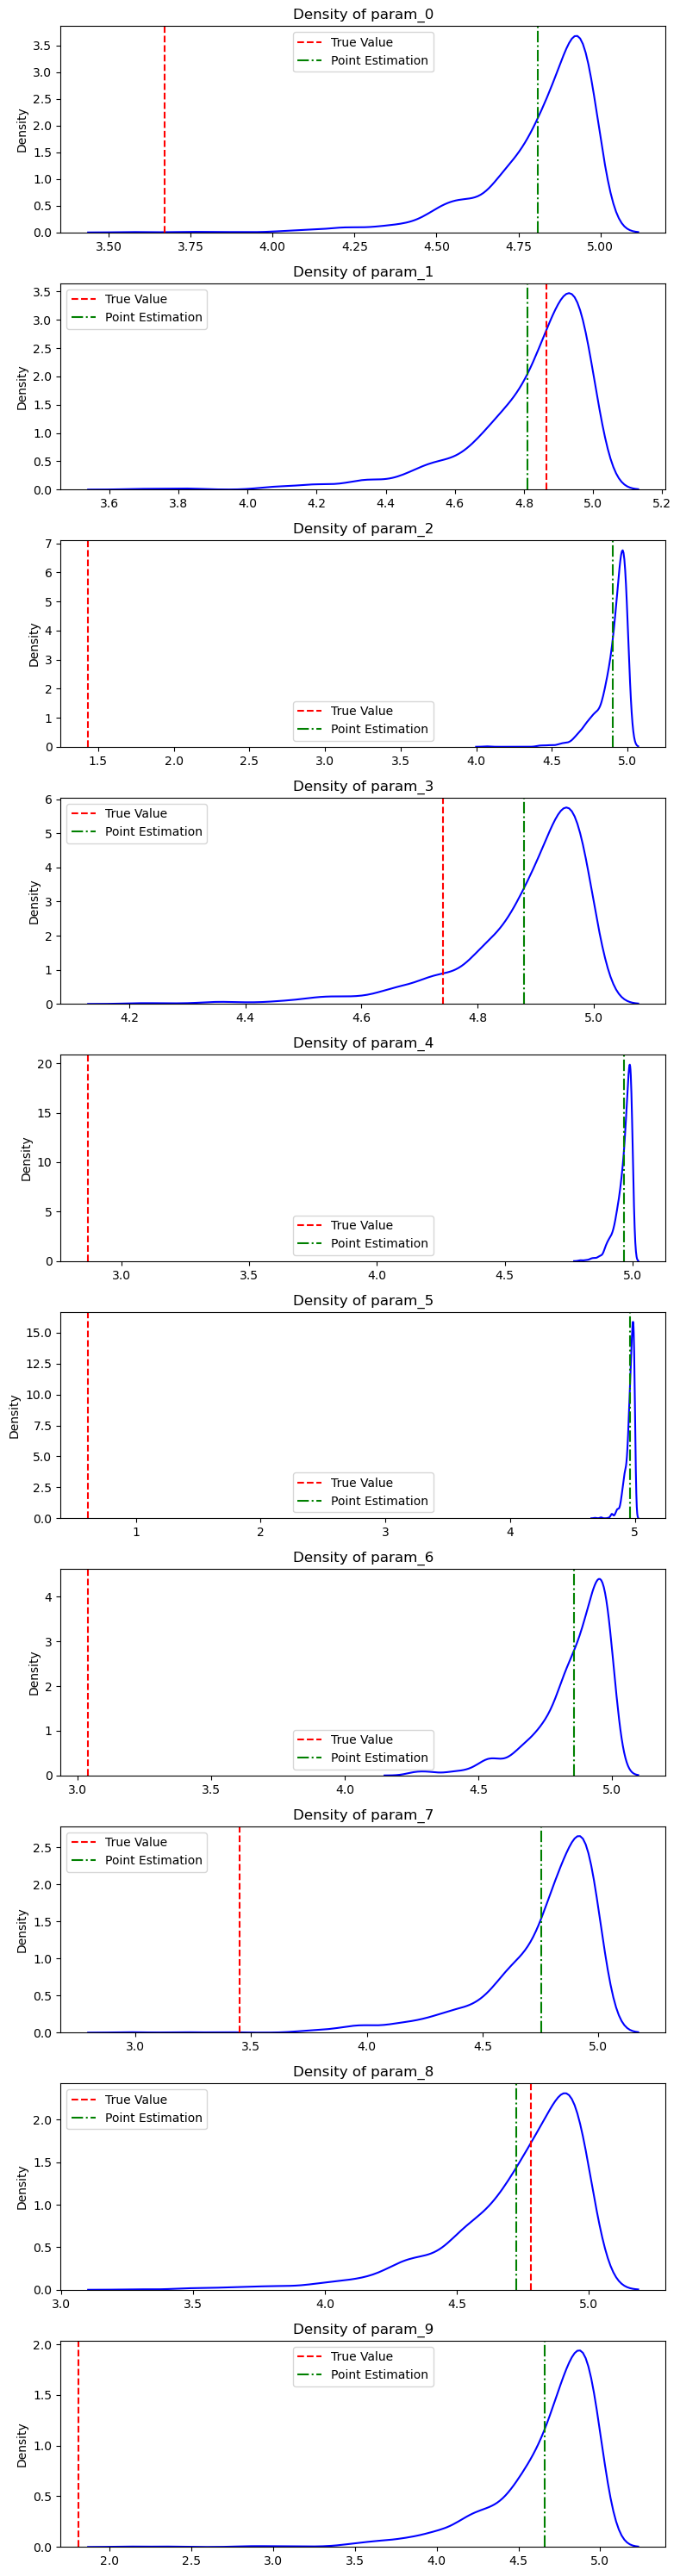

In [12]:
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

true_values = test_x[row_idx,:]

point_estimations = posterior_means_array

fig, axes = plt.subplots(len(posterior_samples_Uniform), 1, figsize=(8, len(posterior_samples_Uniform) * 3))

for i, (param_name, samples) in enumerate(posterior_samples_Uniform.items()):
    if len(posterior_samples_Uniform) > 1:
        ax = axes[i]
    else:
        ax = axes
    sns.kdeplot(samples.detach().numpy(), ax=ax, color='blue')
    ax.set_title(f'Density of {param_name}')
    
    # 标记 true_values 和 point_estimations
    if true_values is not None and i < len(true_values):
        ax.axvline(true_values[i], color='red', linestyle='--', label='True Value')
    if point_estimations is not None and i < len(point_estimations):
        ax.axvline(point_estimations[i], color='green', linestyle='-.', label='Point Estimation')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
posterior_samples_Uniform

In [ ]:
posterior_samples_Uniform['param_1']

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


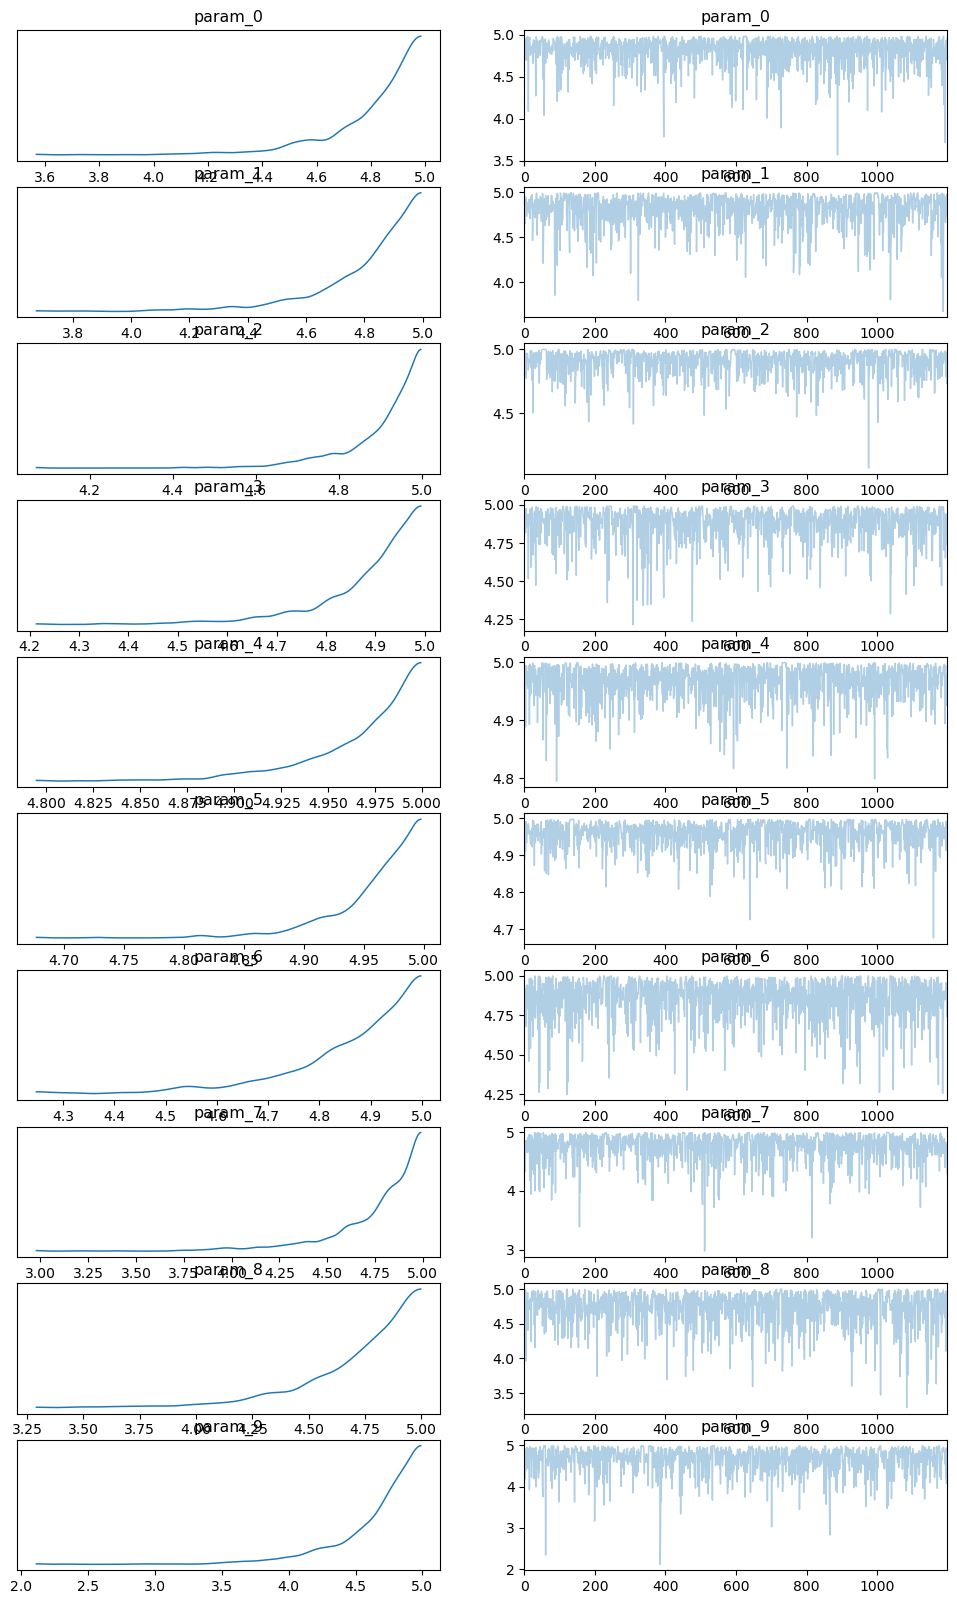

arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  4.809  0.179     4.471      4.985      0.004    0.003    1368.0   
param_1  4.811  0.186     4.440      4.995      0.006    0.004     679.0   
param_2  4.903  0.099     4.706      4.998      0.003    0.002     467.0   
param_3  4.880  0.116     4.649      4.993      0.003    0.002     690.0   
param_4  4.967  0.032     4.904      5.000      0.001    0.001     735.0   
param_5  4.959  0.038     4.887      4.998      0.001    0.001     589.0   
param_6  4.856  0.136     4.557      4.998      0.003    0.002    1307.0   
param_7  4.754  0.248     4.237      4.991      0.007    0.005     799.0   
param_8  4.724  0.260     4.220      4.999      0.007    0.005    1014.0   
param_9  4.660  0.333     3.997      4.990      0.010    0.007     751.0   

         ess_tail  r_hat  
param_0     575.0    NaN  
param_1     614.0    NaN  
param_2     268.0    NaN  
param_3     382.0    NaN  
param_4     336.0    NaN  
p

In [13]:
idata = az.from_pyro(mcmc_result_Uniform)
az.plot_trace(idata)
plt.show()


summary = az.summary(idata, hdi_prob=0.95)
print(summary)

# **End**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Gaussian distribution
mu = 0  # mean
sigma = 1  # standard deviation

# Generate random samples from the Gaussian distribution
x = np.random.normal(mu, sigma, 10000)
# x = np.random.uniform(mu, sigma, 10000)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')


# Labeling the plot

plt.xlabel("X values")
plt.ylabel("Probability Density")

plt.show()


In [ ]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the affine transformation function
def affine_transform(x, loc=1.3, scale=2.6):
    return loc + scale * x

In [ ]:
# Apply sigmoid transform to the generated data
# x_1 = affine_transform(x,3,1.5)
x_2 = sigmoid(x)
x_transformed = affine_transform(x_2)

# Plot the transformed distribution
plt.figure(figsize=(8, 6))
plt.hist(x_transformed, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Labeling the plot
plt.xlabel("Transformed X values")
plt.ylabel("Probability Density")

plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

row_idx = 0

input_point = test_y[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = 400)

# 假设x是已知数据
x = local_train_x[:,3] 

# 1. 绘制直方图
plt.hist(x, bins=30, density=True, alpha=0.6, color='g')

# 2. 尝试拟合正态分布
mu, std = stats.norm.fit(x)

# 3. 绘制拟合的正态分布曲线
xmin, xmax = plt.xlim()
x_plot = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x_plot, mu, std)
plt.plot(x_plot, p, 'k', linewidth=2)
title = f"Fit results: mu = {mu:.2f}, std = {std:.2f}"
plt.title(title)
plt.show()

# 4. 生成与数据类似的随机数
random_data = np.random.normal(mu, std, len(x))


In [ ]:
test_x[0,:]